In [1]:
import os
import getpass
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import SystemMessage, HumanMessage, AnyMessage, ToolMessage
from dotenv import load_dotenv
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnableLambda, RunnableBranch
from langchain_core.tools import tool, StructuredTool
import yfinance as yf
import requests
from typing import Dict, Any, List, Optional
from langsmith import traceable
from tavily import TavilyClient
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass, fields, field
import json
from typing_extensions import TypedDict, Annotated, Literal
import operator
from IPython.display import Markdown
from bs4 import BeautifulSoup
from urllib.request import urlopen
from enum import Enum
import os
import google.oauth2.credentials
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors

# %%
load_dotenv()

# %%
llm = ChatGroq(model_name='Gemma2-9b-it', api_key=os.getenv('GROQ_API_KEY'))

# %% [markdown]
# ## Prompts for Web Research

# %%
query_writer_instruction_web = """Your goal is to generate a targeted web search query related to financial investments or any finance-related topic specified by the user.

<TOPIC>
{finance_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the finance topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "best index funds for long-term investment 2025",
    "aspect": "investment strategy",
    "rationale": "Identifying top-performing index funds for long-term portfolio growth"
}}
</EXAMPLE>

Provide your response in JSON format:
"""

summarizer_instruction_web = """<GOAL>
Generate a high-quality summary of the web search results, focusing on financial investments or the specific finance-related topic requested by the user.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant financial insights, trends, or strategies from the search results.
2. Ensure a coherent flow of information while keeping it concise and actionable.

When EXTENDING an existing summary:
1. Read the existing summary and new search results carefully.
2. Compare the new information with the existing summary.
3. For each piece of new information:
    a. If it builds on an existing point, integrate it smoothly.
    b. If it introduces a new relevant aspect, add a separate paragraph.
    c. If it’s irrelevant to financial investments, ignore it.
4. Ensure all additions align with the user’s finance-related query.
5. Verify that the final output differs from the original summary while improving its depth.

<FORMATTING>
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.
</FORMATTING>
"""

reflection_instructions_web = """You are an expert financial research assistant analyzing a summary about {finance_topic}.

<GOAL>
1. Identify missing details or areas that need deeper exploration.
2. Generate a follow-up question to help expand financial knowledge.
3. Focus on investment strategies, market trends, risk factors, regulations, or financial instruments that weren’t fully covered.
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and provides necessary context for a web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- "knowledge_gap": Describe what financial information is missing or unclear.
- "follow_up_query": Write a specific question to address this gap.
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary does not mention tax implications of investing in ETFs vs. mutual funds.",
    "follow_up_query": "What are the tax advantages and disadvantages of ETFs compared to mutual funds?"
}}
</EXAMPLE>

Provide your analysis in JSON format:
"""

# %% [markdown]
# ## State Definition

# %%
class State(TypedDict):
    # The state now includes a "Parallel" route and will eventually include self-evaluation.
    route: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender', 'Parallel']
    research_topic: str
    search_query: str
    web_research_results: List[str]
    sources_gathered: List[str]
    research_loop_count: int
    running_summary: str
    messages: List[Any]  # Contains HumanMessage/ToolMessage objects

def create_initial_state(user_query: str) -> State:
    return {
        "route": None,
        "research_topic": user_query,
        "search_query": "",
        "web_research_results": [],
        "sources_gathered": [],
        "research_loop_count": 0,
        "running_summary": "",
        "messages": [HumanMessage(content=user_query)]
    }

# %% [markdown]
# ## Routing Step

# %%
class Route_First_Step(BaseModel):
    # Now includes "Parallel" as an option.
    step: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender', 'Parallel'] = Field(
        None,
        description='Determine whether to perform a web search, answer a normal question, perform financial analysis, recommend YouTube videos, or run parallel branches.'
    )

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    search_api: SearchAPI = SearchAPI(os.environ.get("SEARCH_API", "tavily"))
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")
    ollama_base_url: str = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/")

    @classmethod
    def from_runnable_config(cls, config: Optional[RunnableConfig] = None) -> "Configuration":
        configurable = config["configurable"] if config and "configurable" in config else {}
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

# %% [markdown]
# ## Web Research Functions

# %%
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    api_key = os.environ['TAVILY_API_KEY']
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    from tavily import TavilyClient  # Imported here for modularity
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query, max_results=max_results, include_raw_content=include_raw_content)

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    formatted_text = "Sources:\n\n"
    for source in unique_sources.values():
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            char_limit = max_tokens_per_source * 4
            raw_content = source.get('raw_content', '') or ''
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()

def format_sources(search_results):
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def generate_query(state: State, config: RunnableConfig):
    prompt = query_writer_instruction_web.format(finance_topic=state["research_topic"]) + "\nGenerate a query for web search:"
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        query_data = json.loads(output_text)
        return {"search_query": query_data['query']}
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return {"search_query": f"comprehensive analysis of {state['research_topic']}"}

def web_research(state: State, config: RunnableConfig):
    configurable = Configuration.from_runnable_config(config)
    search_api = configurable.search_api.value if isinstance(configurable.search_api, Enum) is False else configurable.search_api.value
    if search_api == "tavily":
        search_results = tavily_search(state["search_query"], include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")
    return {
        "sources_gathered": [format_sources(search_results)],
        "research_loop_count": state["research_loop_count"] + 1,
        "web_research_results": [search_str]
    }

def summarize_sources(state: State, config: RunnableConfig):
    existing_summary = state['running_summary']
    most_recent_web_research = state['web_research_results'][-1]
    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )
    prompt = summarizer_instruction_web + "\n" + human_message_content
    result = llm.invoke(prompt)
    running_summary = result.content
    while "<think>" in running_summary and "</think>" in running_summary:
        start = running_summary.find("<think>")
        end = running_summary.find("</think>") + len("</think>")
        running_summary = running_summary[:start] + running_summary[end:]
    return {"running_summary": running_summary}

def reflect_on_summary(state: State, config: RunnableConfig):
    prompt = reflection_instructions_web.format(finance_topic=state['research_topic']) \
             + "\nIdentify a knowledge gap and generate a follow-up web search query based on our existing knowledge: " \
             + state['running_summary']
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        follow_up_query = json.loads(output_text)
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from reflect_on_summary. Response was:", output_text)
        follow_up_query = {"follow_up_query": f"Tell me more about {state['research_topic']}"}
    query = follow_up_query.get('follow_up_query')
    if not query:
        return {"search_query": f"Tell me more about {state['research_topic']}"}
    return {"search_query": query}

def finalize_summary(state: State):
    all_sources = "\n".join(source for source in state['sources_gathered'])
    final_summary = f"## Web Research Summary\n\n{state['running_summary']}\n\n### Sources:\n{all_sources}"
    final_message = HumanMessage(content=final_summary)
    return {"running_summary": final_summary, "messages": [final_message]}

def route_research(state: State, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state['research_loop_count'] < configurable.max_web_research_loops:
        return "web_research"
    return "finalize_summary"

# %% [markdown]
# ## Financial Analysis Tools & Functions

# %%from langchain_core.tools import tool, StructuredTool
import yfinance as yf



@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. company_address: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    e.g. company_address: MSFT
    Returns last close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    e.g. company_address: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    e.g. company_address: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    e.g. company_address: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. company_address: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['debtToEquity']

finance_tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]

finance_tool_map = {t.name: t for t in finance_tools}
llm_normal = llm
normal_query_prompt = """
You are a financial analyst. Please answer the user's question based on what you know, don't make up anything.
"""

def answer_normal_query(state: State):
    messages = state.get('messages', [])
    system_message = SystemMessage(content=normal_query_prompt + "\nFormat your response in Markdown.")
    response = llm_normal.invoke([system_message] + messages)
    markdown_response = f"## Normal Query Response\n\n{response.content}"
    return {"running_summary": markdown_response, "messages": [HumanMessage(content=markdown_response)]}

llm_financial_analysis = llm.bind_tools(finance_tools, tool_choice='auto')
financial_analysis_prompt = """
You are a financial analyst. You are given tools for accurate data.
"""

def call_llm(state: State):
    messages = state['messages']
    system_prompt = financial_analysis_prompt + "\nFormat your response in Markdown."
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_financial_analysis.invoke(messages)
    return {'messages': [message]}

def exists_action(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

def take_action(state: State):
    tool_calls = state['messages'][-1].tool_calls
    tool_results = []
    for t in tool_calls:
        try:
            tool_func = finance_tool_map[t['name']]
            result = tool_func.invoke(t['args'])
        except KeyError:
            result = f"Error: Tool {t['name']} not found"
        except Exception as e:
            result = f"Error executing tool: {str(e)}"
        tool_results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
    markdown_output = "## Financial Analysis Results\n\n"
    for result in tool_results:
        markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    return {'messages': tool_results, 'running_summary': markdown_output}

def format_financial_analysis(state: State):
    messages = state['messages']
    tool_results = [msg for msg in messages if isinstance(msg, ToolMessage)]
    if tool_results:
        markdown_output = "## Financial Analysis Results\n\n"
        for result in tool_results:
            markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    else:
        markdown_output = f"## Financial Analysis\n\n{messages[-1].content}"
    return {"running_summary": markdown_output, "messages": [HumanMessage(content=markdown_output)]}

# %% [markdown]
# ## YouTube Video Recommendation Integration

# %%
class YouTubeVideoRecommender:
    def __init__(self, api_key):
        self.api_key = api_key
        self.youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
    
    def get_channel_id(self, channel_name):
        request = self.youtube.search().list(
            part="snippet",
            q=channel_name,
            type="channel",
            maxResults=1
        )
        response = request.execute()
        if response['items']:
            return response['items'][0]['id']['channelId']
        return None
    
    def search_videos_in_channel(self, channel_id, query, max_results=10):
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel_id,
            q=query,
            type="video",
            maxResults=max_results
        )
        response = request.execute()
        videos = []
        for item in response['items']:
            video_id = item['id']['videoId']
            title = item['snippet']['title']
            description = item['snippet']['description']
            published_at = item['snippet']['publishedAt']
            thumbnail = item['snippet']['thumbnails']['high']['url']
            channel_title = item['snippet']['channelTitle']
            videos.append({
                'video_id': video_id,
                'title': title,
                'description': description,
                'published_at': published_at,
                'thumbnail': thumbnail,
                'channel': channel_title,
                'url': f"https://www.youtube.com/watch?v={video_id}"
            })
        return videos

    def recommend_videos(self, query, channels, videos_per_channel=5):
        all_videos = []
        for channel in channels:
            if channel.startswith('UC') and len(channel) == 24:
                channel_id = channel
            else:
                channel_id = self.get_channel_id(channel)
                if not channel_id:
                    print(f"Could not find channel: {channel}")
                    continue
            videos = self.search_videos_in_channel(channel_id, query, videos_per_channel)
            all_videos.extend(videos)
        return all_videos

def youtube_recommend(state: State, config: RunnableConfig):
    api_key = os.getenv("YOUTUBE_API_KEY")
    if not api_key:
        raise ValueError("YOUTUBE_API_KEY is not set")
    recommender = YouTubeVideoRecommender(api_key)
    favorite_channels = [
        "ZEE Business",
        "Economic Times",
        "Times Now",
        "Times Now Business",
        "Times Now News",
        "Times Now Politics",
        "Times Now Sports",
        "Times Now Science",
        "Times Now Technology",
        "Pranjal Kamra",
        "Yadnya Investment Academy",
        "CA Rachana Phadke Ranade",
        "Invest Aaj For Kal",
        "Market Gurukul",
        "Warikoo",
        "Asset Yogi",
        "Trading Chanakya",
        "Trade Brains",
        "B Wealthy",
        "Capital Pritika",
        "The Urban Fight",
        "Kritika Yadav",
        "Gurleen Kaur Tikku"
    ]
    query = state["research_topic"]
    recommendations = recommender.recommend_videos(query, favorite_channels, videos_per_channel=1)
    if not recommendations:
        summary = f"No matching videos found for query: {query}"
    else:
        summary = f"## YouTube Video Recommendations for '{query}'\n\n"
        for i, video in enumerate(recommendations, 1):
            summary += f"### {i}. {video['title']}\n"
            summary += f"- Channel: {video['channel']}\n"
            summary += f"- URL: {video['url']}\n"
            summary += f"- Published: {video['published_at']}\n\n"
    return {"running_summary": summary, "messages": [HumanMessage(content=summary)]}

# %% [markdown]
# ## Parallel Branch Execution
#
# This node demonstrates running two branches concurrently (financial analysis and normal query answer)
# and merging their outputs.

def merge_branches(state_a: State, state_b: State) -> State:
    merged_summary = (
        state_a.get("running_summary", "")
        + "\n\n"
        + state_b.get("running_summary", "")
    )
    merged_messages = state_a.get("messages", []) + state_b.get("messages", [])
    merged_state = state_a.copy()
    merged_state["running_summary"] = merged_summary
    merged_state["messages"] = merged_messages
    return merged_state

def run_parallel_branches(state: State, config: RunnableConfig) -> State:
    result_financial = call_llm(state)
    result_normal = answer_normal_query(state)
    merged_state = merge_branches(result_financial, result_normal)
    return merged_state

def parallel_branches(state: State, config: RunnableConfig):
    merged_state = run_parallel_branches(state, config)
    return merged_state

# %% [markdown]
# ## Self Evaluation Integration
#
# The self_evaluate function uses the LLM to assess the final answer.
# It takes a string in the format: "query|||response|||sources" and returns a confidence score and explanation.

def self_evaluate(input_text):
    parts = input_text.split("|||")
    query = parts[0]
    response = parts[1]
    sources = parts[2] if len(parts) > 2 else ""
    
    evaluation_prompt = f"""
    Evaluate the following response to the query:
    
    QUERY: {query}
    RESPONSE: {response}
    SOURCES: {sources}
    
    Assess based on:
    1. Factual accuracy (Does it match the sources?)
    2. Completeness (Does it address all aspects of the query?)
    3. Relevance (Is the information relevant to the query?)
    4. Hallucination (Does it contain information not supported by sources?)
    
    Return a confidence score from 0-10 and a brief explanation.
    """
    
    evaluation = llm.predict(evaluation_prompt)
    return evaluation

def evaluate_response(state: State, config: RunnableConfig):
    query = state.get("research_topic", "")
    response = state.get("running_summary", "")
    sources = "\n".join(state.get("sources_gathered", [])) or "No sources available"
    input_text = f"{query}|||{response}|||{sources}"
    evaluation = self_evaluate(input_text)
    final_summary = response + "\n\n## Self Evaluation\n\n" + evaluation
    return {"running_summary": final_summary, "messages": [HumanMessage(content=final_summary)]}

# %% [markdown]
# ## Final Route Builder

# %%
def get_route(state: State) -> str:
    return state["route"]

def call_route_first_step(state: State):
    router_response = llm.with_structured_output(Route_First_Step).invoke(state["research_topic"])
    return {"route": router_response.step}

def update_router():
    final_router = StateGraph(State)
    final_router.add_node("route_first_step", call_route_first_step)
    final_router.add_node("generate_query", generate_query)
    final_router.add_node("web_research", web_research)
    final_router.add_node("summarize_sources", summarize_sources)
    final_router.add_node("reflect_on_summary", reflect_on_summary)
    final_router.add_node("finalize_summary", finalize_summary)
    final_router.add_node('call_llm', call_llm)
    final_router.add_node('take_action', take_action)
    final_router.add_node('format_financial_analysis', format_financial_analysis)
    final_router.add_node('answer_normal_query', answer_normal_query)
    final_router.add_node('youtube_recommend', youtube_recommend)
    #final_router.add_node('parallel_branches', parallel_branches)
    # New self-evaluation node:
    final_router.add_node('self_evaluate_final', evaluate_response)
    
    final_router.add_edge(START, "route_first_step")
    final_router.add_conditional_edges("route_first_step", get_route, {
        'Web_query': 'generate_query',
        'Normal_query': 'answer_normal_query',
        'Financial_Analysis': 'call_llm',
        'YouTube_Recommender': 'youtube_recommend',
        'Parallel': 'parallel_branches'
    })
    
    # Instead of directly ending, final branches now route to self_evaluate_final:
    final_router.add_edge("answer_normal_query", "self_evaluate_final")
    final_router.add_conditional_edges(
        "call_llm",
        exists_action,
        {True: "take_action", False: "format_financial_analysis"}
    )
    final_router.add_edge("take_action", "format_financial_analysis")
    final_router.add_edge("format_financial_analysis", "self_evaluate_final")
    final_router.add_edge("generate_query", "web_research")
    final_router.add_edge("web_research", "summarize_sources")
    final_router.add_edge("summarize_sources", "reflect_on_summary")
    final_router.add_conditional_edges("reflect_on_summary", route_research)
    final_router.add_edge("finalize_summary", "self_evaluate_final")
    final_router.add_edge("youtube_recommend", "self_evaluate_final")
    final_router.add_edge("parallel_branches", "self_evaluate_final")
    
    final_router.add_edge("self_evaluate_final", END)
    
    return final_router.compile()

def validate_state_transition(old_state: State, new_state: State):
    required_fields = set(State.__annotations__.keys())
    missing = required_fields - set(new_state.keys())
    if missing:
        raise ValueError(f"Missing state updates for: {missing}")
    return True

# %% [markdown]
# ## Running the Integrated Agent

In [2]:
# %%
final_model = update_router()
# %%

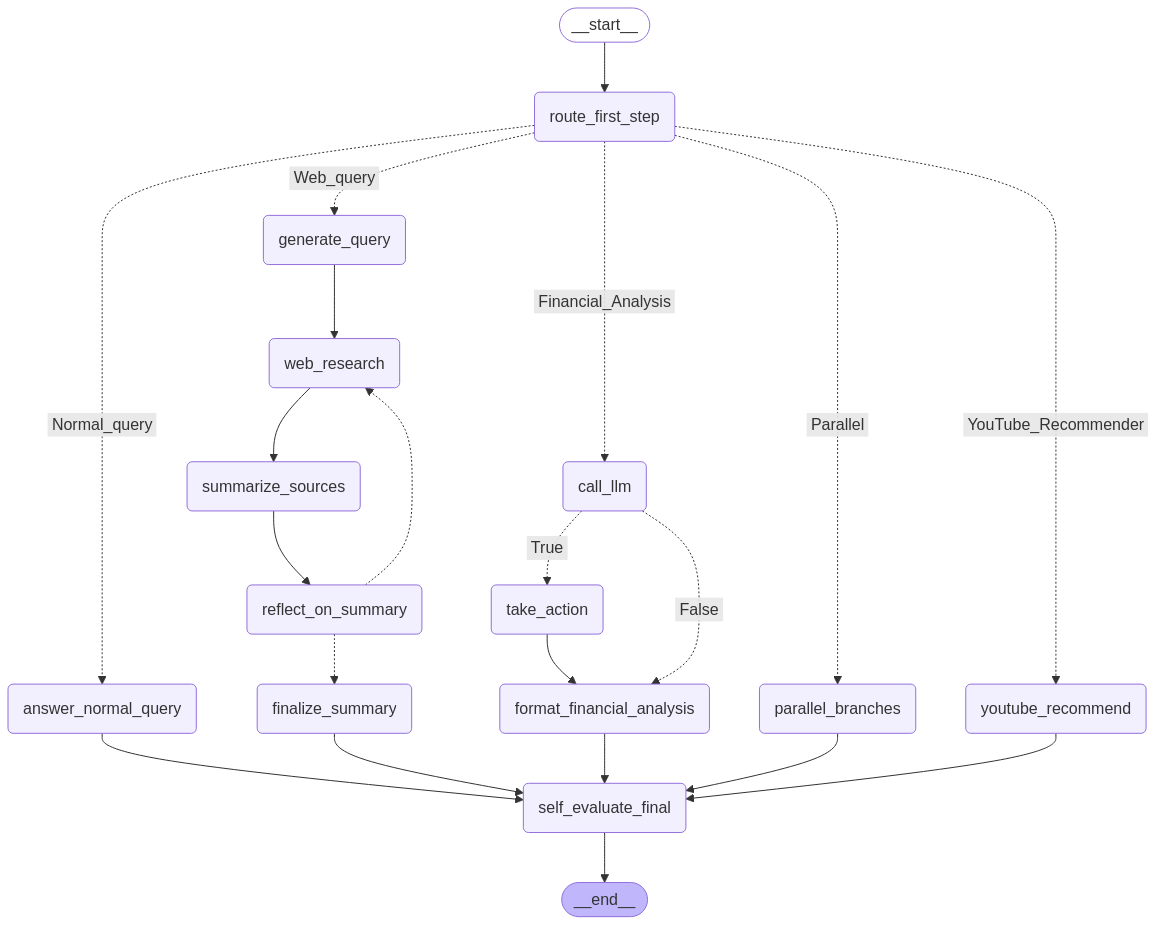

In [3]:
import requests

# Save the original requests.Session.request method
_original_request = requests.Session.request

def new_request(self, method, url, **kwargs):
    # If no timeout is specified, use a 60-second timeout.
    if 'timeout' not in kwargs:
        kwargs['timeout'] = 60  # Increase the timeout from 10 to 60 seconds.
    return _original_request(self, method, url, **kwargs)

# Monkey-patch the request method.
requests.Session.request = new_request

# Now, when you call draw_mermaid_png, it will use the new timeout.
try:
    graph_png = final_model.get_graph().draw_mermaid_png()
    display(Image(graph_png))
except Exception as e:
    print("Graph visualization failed:", e)


In [56]:
initial_state = create_initial_state("What are the latest trends in sustainable investing?")
# Optionally, you can set the route manually for testing:
# initial_state["route"] = "YouTube_Recommender"  
# initial_state["route"] = "Parallel"              
result = final_model.invoke(initial_state)

Error parsing JSON: Expecting value: line 1 column 1 (char 0)


RecursionError: maximum recursion depth exceeded in comparison

In [57]:
initial_state['route']

In [58]:
initial_state

{'route': None,
 'research_topic': 'What are the latest trends in sustainable investing?',
 'search_query': '',
 'web_research_results': [],
 'sources_gathered': [],
 'research_loop_count': 0,
 'running_summary': '',
 'messages': [HumanMessage(content='What are the latest trends in sustainable investing?', additional_kwargs={}, response_metadata={})]}

In [59]:
Markdown(result['messages'][-1].content)

# %%


## Financial Analysis Results

### Total Revenue

Error executing tool: maximum recursion depth exceeded in comparison



## Self Evaluation

Confidence Score: 0

**Explanation:**

This response is completely irrelevant and unhelpful. 

* **Factual Accuracy:**  The response provides financial analysis results with an error message, which has no connection to sustainable investing trends.
* **Completeness:** It fails to address any aspect of the query about sustainable investing.
* **Relevance:** The information about "Total Revenue" and the error message are entirely unrelated to the user's question.
* **Hallucination:** While there's no clear fabrication of facts, the response hallucinates a connection between financial data and sustainable investing trends where none exists. 


The response seems to be a technical glitch or an incorrect output from a tool, rather than a meaningful attempt to answer the query.  


In [60]:
initial_state = create_initial_state("What does stock mean?")
# Optionally, you can set the route manually for testing:
# initial_state["route"] = "YouTube_Recommender"  
# initial_state["route"] = "Parallel"              
result = final_model.invoke(initial_state)

In [61]:
Markdown(result['messages'][-1].content)

## Financial Analysis

A stock represents a share of ownership in a publicly traded company. 


## Self Evaluation

## Response Evaluation:

**Factual Accuracy:** 10 - The definition provided is accurate and commonly accepted.

**Completeness:** 7 - While the definition is accurate, it lacks depth. It doesn't mention different types of stocks (common, preferred), stock market mechanics (buying/selling), or the purpose of investing in stocks.

**Relevance:** 10 - The information directly addresses the query "What does stock mean?"

**Hallucination:** 0 - The response does not introduce any fabricated information.

**Confidence Score:** 8

**Explanation:** The response accurately defines "stock" but could be improved by providing more context and details about stock ownership, trading, and investment purposes. 




In [62]:
initial_state = create_initial_state("What is EBIDTA of Apple Inc?")
# Optionally, you can set the route manually for testing:
# initial_state["route"] = "YouTube_Recommender"  
# initial_state["route"] = "Parallel"              
result = final_model.invoke(initial_state)

In [63]:
result['messages']

[HumanMessage(content='## Financial Analysis Results\n\n### Ebitda\n\nError executing tool: maximum recursion depth exceeded in comparison\n\n\n\n## Self Evaluation\n\n## Response Evaluation: \n\n**Confidence Score:** 0\n\n**Explanation:**\n\nThe response is completely unhelpful and indicates a failure on the part of the system. \n\n* **Factual Accuracy:**  Impossible to assess as there is no actual data provided.\n* **Completeness:**  Fails to provide any information about Apple Inc.\'s EBITDA.\n* **Relevance:**  The response is minimally relevant, mentioning "EBITDA" but not delivering the actual value.\n* **Hallucination:**  While there\'s no fabricated data, the error message suggests the system attempted to access and process information that led to a failure, potentially indicating internal issues rather than intentional fabrication. \n\n\nThe "maximum recursion depth exceeded in comparison" error suggests a problem with the system\'s internal logic or data structure, not necessa

In [64]:
Markdown(result['messages'][-1].content)

## Financial Analysis Results

### Ebitda

Error executing tool: maximum recursion depth exceeded in comparison



## Self Evaluation

## Response Evaluation: 

**Confidence Score:** 0

**Explanation:**

The response is completely unhelpful and indicates a failure on the part of the system. 

* **Factual Accuracy:**  Impossible to assess as there is no actual data provided.
* **Completeness:**  Fails to provide any information about Apple Inc.'s EBITDA.
* **Relevance:**  The response is minimally relevant, mentioning "EBITDA" but not delivering the actual value.
* **Hallucination:**  While there's no fabricated data, the error message suggests the system attempted to access and process information that led to a failure, potentially indicating internal issues rather than intentional fabrication. 


The "maximum recursion depth exceeded in comparison" error suggests a problem with the system's internal logic or data structure, not necessarily a hallucination.  However, the inability to deliver a simple factual answer makes the response worthless. 


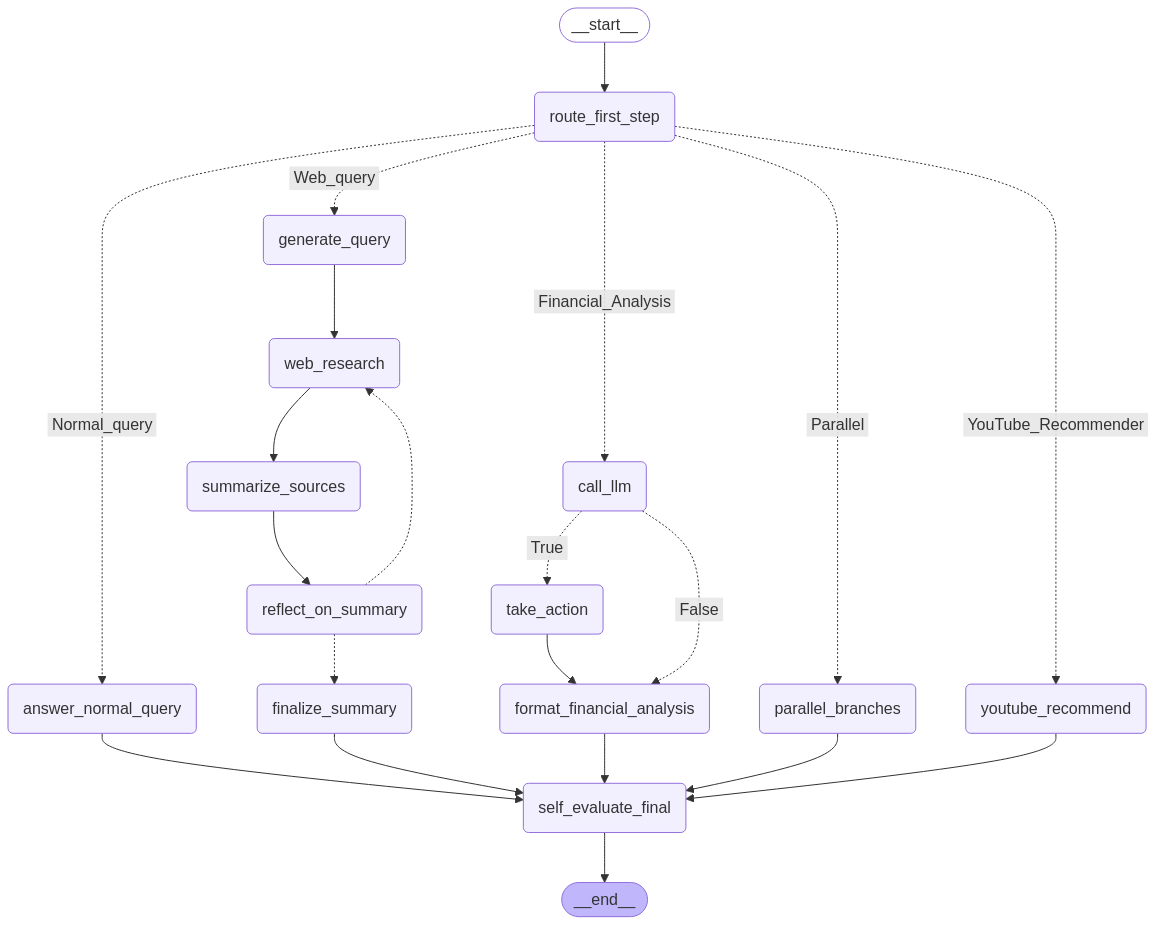

In [5]:
# %%
import os
import json
import operator
import re
from enum import Enum
from dataclasses import dataclass, fields
from typing import Any, Dict, List, Optional
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

# IPython for display
from IPython.display import Image, display, Markdown

# LangChain and related tools
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain_core.tools import tool, StructuredTool

# For financial data via yfinance
import yfinance as yf

# For web search and HTML parsing
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen

# For environment variables
from dotenv import load_dotenv

# For YouTube video recommendations
import googleapiclient.discovery
import googleapiclient.errors

# For state graph
from langgraph.graph import StateGraph, START, END

# %%
load_dotenv()

# %%
llm = ChatGroq(model_name='Gemma2-9b-it', api_key=os.getenv('GROQ_API_KEY'))

# %% [markdown]
# ## Prompts for Web Research

# %%
query_writer_instruction_web = """Your goal is to generate a targeted web search query related to financial investments or any finance-related topic specified by the user.

<TOPIC>
{finance_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the finance topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "best index funds for long-term investment 2025",
    "aspect": "investment strategy",
    "rationale": "Identifying top-performing index funds for long-term portfolio growth"
}}
</EXAMPLE>

Provide your response in JSON format:
"""

summarizer_instruction_web = """<GOAL>
Generate a high-quality summary of the web search results, focusing on financial investments or the specific finance-related topic requested by the user.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant financial insights, trends, or strategies from the search results.
2. Ensure a coherent flow of information while keeping it concise and actionable.

When EXTENDING an existing summary:
1. Read the existing summary and new search results carefully.
2. Compare the new information with the existing summary.
3. For each piece of new information:
    a. If it builds on an existing point, integrate it smoothly.
    b. If it introduces a new relevant aspect, add a separate paragraph.
    c. If it’s irrelevant to financial investments, ignore it.
4. Ensure all additions align with the user’s finance-related query.
5. Verify that the final output differs from the original summary while improving its depth.

<FORMATTING>
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.
</FORMATTING>
"""

reflection_instructions_web = """You are an expert financial research assistant analyzing a summary about {finance_topic}.

<GOAL>
1. Identify missing details or areas that need deeper exploration.
2. Generate a follow-up question to help expand financial knowledge.
3. Focus on investment strategies, market trends, risk factors, regulations, or financial instruments that weren’t fully covered.
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and provides necessary context for a web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- "knowledge_gap": Describe what financial information is missing or unclear.
- "follow_up_query": Write a specific question to address this gap.
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary does not mention tax implications of investing in ETFs vs. mutual funds.",
    "follow_up_query": "What are the tax advantages and disadvantages of ETFs compared to mutual funds?"
}}
</EXAMPLE>

Provide your analysis in JSON format:
"""

# %% [markdown]
# ## State Definition

# %%
class State(TypedDict):
    # The state now includes a "Parallel" route and will eventually include self-evaluation.
    route: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender', 'Parallel']
    research_topic: str
    search_query: str
    web_research_results: List[str]
    sources_gathered: List[str]
    research_loop_count: int
    running_summary: str
    messages: List[Any]  # Contains HumanMessage/ToolMessage objects

def create_initial_state(user_query: str) -> State:
    return {
        "route": None,
        "research_topic": user_query,
        "search_query": "",
        "web_research_results": [],
        "sources_gathered": [],
        "research_loop_count": 0,
        "running_summary": "",
        "messages": [HumanMessage(content=user_query)]
    }

# %% [markdown]
# ## Routing Step

# %%
class Route_First_Step(BaseModel):
    # Now includes "Parallel" as an option.
    step: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender', 'Parallel'] = Field(
        None,
        description='Determine whether to perform a web search, answer a normal question, perform financial analysis, recommend YouTube videos, or run parallel branches.'
    )

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    search_api: SearchAPI = SearchAPI(os.environ.get("SEARCH_API", "tavily"))
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")
    ollama_base_url: str = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/")

    @classmethod
    def from_runnable_config(cls, config: Optional[RunnableConfig] = None) -> "Configuration":
        configurable = config["configurable"] if config and "configurable" in config else {}
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

# %% [markdown]
# ## Web Research Functions

# %%
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    api_key = os.environ['TAVILY_API_KEY']
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    from tavily import TavilyClient  # Imported here for modularity
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query, max_results=max_results, include_raw_content=include_raw_content)

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    formatted_text = "Sources:\n\n"
    for source in unique_sources.values():
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            char_limit = max_tokens_per_source * 4
            raw_content = source.get('raw_content', '') or ''
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()

def format_sources(search_results):
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def generate_query(state: State, config: RunnableConfig):
    prompt = query_writer_instruction_web.format(finance_topic=state["research_topic"]) + "\nGenerate a query for web search:"
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        query_data = json.loads(output_text)
        return {"search_query": query_data['query']}
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return {"search_query": f"comprehensive analysis of {state['research_topic']}"}

def web_research(state: State, config: RunnableConfig):
    configurable = Configuration.from_runnable_config(config)
    search_api = configurable.search_api.value if isinstance(configurable.search_api, Enum) is False else configurable.search_api.value
    if search_api == "tavily":
        search_results = tavily_search(state["search_query"], include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")
    return {
        "sources_gathered": [format_sources(search_results)],
        "research_loop_count": state["research_loop_count"] + 1,
        "web_research_results": [search_str]
    }

def summarize_sources(state: State, config: RunnableConfig):
    existing_summary = state['running_summary']
    most_recent_web_research = state['web_research_results'][-1]
    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )
    prompt = summarizer_instruction_web + "\n" + human_message_content
    result = llm.invoke(prompt)
    running_summary = result.content
    while "<think>" in running_summary and "</think>" in running_summary:
        start = running_summary.find("<think>")
        end = running_summary.find("</think>") + len("</think>")
        running_summary = running_summary[:start] + running_summary[end:]
    return {"running_summary": running_summary}

def reflect_on_summary(state: State, config: RunnableConfig):
    prompt = reflection_instructions_web.format(finance_topic=state['research_topic']) \
             + "\nIdentify a knowledge gap and generate a follow-up web search query based on our existing knowledge: " \
             + state['running_summary']
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        follow_up_query = json.loads(output_text)
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from reflect_on_summary. Response was:", output_text)
        follow_up_query = {"follow_up_query": f"Tell me more about {state['research_topic']}"}
    query = follow_up_query.get('follow_up_query')
    if not query:
        return {"search_query": f"Tell me more about {state['research_topic']}"}
    return {"search_query": query}

def finalize_summary(state: State):
    all_sources = "\n".join(source for source in state['sources_gathered'])
    final_summary = f"## Web Research Summary\n\n{state['running_summary']}\n\n### Sources:\n{all_sources}"
    final_message = HumanMessage(content=final_summary)
    return {"running_summary": final_summary, "messages": [final_message]}

def route_research(state: State, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state['research_loop_count'] < configurable.max_web_research_loops:
        return "web_research"
    return "finalize_summary"

# %% [markdown]
# ## Financial Analysis Tools & Functions

# %%
@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. company_address: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    e.g. company_address: MSFT
    Returns last close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    e.g. company_address: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    e.g. company_address: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    e.g. company_address: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. company_address: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['debtToEquity']


finance_tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]
finance_tool_map = {t.name: t for t in finance_tools}

llm_normal = llm
normal_query_prompt = """
You are a financial analyst. Please answer the user's question based on what you know, don't make up anything.
"""

def answer_normal_query(state: State):
    messages = state.get('messages', [])
    system_message = SystemMessage(content=normal_query_prompt + "\nFormat your response in Markdown.")
    response = llm_normal.invoke([system_message] + messages)
    markdown_response = f"## Normal Query Response\n\n{response.content}"
    return {"running_summary": markdown_response, "messages": [HumanMessage(content=markdown_response)]}

llm_financial_analysis = llm.bind_tools(finance_tools, tool_choice='auto')
financial_analysis_prompt = """
You are a financial analyst. You are given tools for accurate data.
"""

def call_llm(state: State):
    messages = state['messages']
    system_prompt = financial_analysis_prompt + "\nFormat your response in Markdown."
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_financial_analysis.invoke(messages)
    return {'messages': [message]}

def exists_action(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

def take_action(state: State):
    tool_calls = state['messages'][-1].tool_calls
    tool_results = []
    for t in tool_calls:
        try:
            tool_func = finance_tool_map[t['name']]
            result = tool_func.invoke(t['args'])
        except KeyError:
            result = f"Error: Tool {t['name']} not found"
        except Exception as e:
            result = f"Error executing tool: {str(e)}"
        tool_results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
    markdown_output = "## Financial Analysis Results\n\n"
    for result in tool_results:
        markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    return {'messages': tool_results, 'running_summary': markdown_output}

def format_financial_analysis(state: State):
    messages = state['messages']
    tool_results = [msg for msg in messages if isinstance(msg, ToolMessage)]
    if tool_results:
        markdown_output = "## Financial Analysis Results\n\n"
        for result in tool_results:
            markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    else:
        markdown_output = f"## Financial Analysis\n\n{messages[-1].content}"
    return {"running_summary": markdown_output, "messages": [HumanMessage(content=markdown_output)]}

# %% [markdown]
# ## YouTube Video Recommendation Integration

# %%
class YouTubeVideoRecommender:
    def __init__(self, api_key):
        self.api_key = api_key
        self.youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
    
    def get_channel_id(self, channel_name):
        request = self.youtube.search().list(
            part="snippet",
            q=channel_name,
            type="channel",
            maxResults=1
        )
        response = request.execute()
        if response['items']:
            return response['items'][0]['id']['channelId']
        return None
    
    def search_videos_in_channel(self, channel_id, query, max_results=10):
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel_id,
            q=query,
            type="video",
            maxResults=max_results
        )
        response = request.execute()
        videos = []
        for item in response['items']:
            video_id = item['id']['videoId']
            title = item['snippet']['title']
            description = item['snippet']['description']
            published_at = item['snippet']['publishedAt']
            thumbnail = item['snippet']['thumbnails']['high']['url']
            channel_title = item['snippet']['channelTitle']
            videos.append({
                'video_id': video_id,
                'title': title,
                'description': description,
                'published_at': published_at,
                'thumbnail': thumbnail,
                'channel': channel_title,
                'url': f"https://www.youtube.com/watch?v={video_id}"
            })
        return videos

    def recommend_videos(self, query, channels, videos_per_channel=5):
        all_videos = []
        for channel in channels:
            if channel.startswith('UC') and len(channel) == 24:
                channel_id = channel
            else:
                channel_id = self.get_channel_id(channel)
                if not channel_id:
                    print(f"Could not find channel: {channel}")
                    continue
            videos = self.search_videos_in_channel(channel_id, query, videos_per_channel)
            all_videos.extend(videos)
        return all_videos

def youtube_recommend(state: State, config: RunnableConfig):
    api_key = os.getenv("YOUTUBE_API_KEY")
    if not api_key:
        raise ValueError("YOUTUBE_API_KEY is not set")
    recommender = YouTubeVideoRecommender(api_key)
    favorite_channels = [
        "ZEE Business",
        "Economic Times",
        "Times Now",
        "Times Now Business",
        "Times Now News",
        "Times Now Politics",
        "Times Now Sports",
        "Times Now Science",
        "Times Now Technology",
        "Pranjal Kamra",
        "Yadnya Investment Academy",
        "CA Rachana Phadke Ranade",
        "Invest Aaj For Kal",
        "Market Gurukul",
        "Warikoo",
        "Asset Yogi",
        "Trading Chanakya",
        "Trade Brains",
        "B Wealthy",
        "Capital Pritika",
        "The Urban Fight",
        "Kritika Yadav",
        "Gurleen Kaur Tikku"
    ]
    query = state["research_topic"]
    recommendations = recommender.recommend_videos(query, favorite_channels, videos_per_channel=1)
    if not recommendations:
        summary = f"No matching videos found for query: {query}"
    else:
        summary = f"## YouTube Video Recommendations for '{query}'\n\n"
        for i, video in enumerate(recommendations, 1):
            summary += f"### {i}. {video['title']}\n"
            summary += f"- Channel: {video['channel']}\n"
            summary += f"- URL: {video['url']}\n"
            summary += f"- Published: {video['published_at']}\n\n"
    return {"running_summary": summary, "messages": [HumanMessage(content=summary)]}

# %% [markdown]
# ## Parallel Branch Execution
#
# This node demonstrates running two branches concurrently (financial analysis and normal query answer)
# and merging their outputs.

def merge_branches(state_a: State, state_b: State) -> State:
    merged_summary = (
        state_a.get("running_summary", "")
        + "\n\n"
        + state_b.get("running_summary", "")
    )
    merged_messages = state_a.get("messages", []) + state_b.get("messages", [])
    merged_state = state_a.copy()
    merged_state["running_summary"] = merged_summary
    merged_state["messages"] = merged_messages
    return merged_state

def run_parallel_branches(state: State, config: RunnableConfig) -> State:
    result_financial = call_llm(state)
    result_normal = answer_normal_query(state)
    merged_state = merge_branches(result_financial, result_normal)
    return merged_state

def parallel_branches(state: State, config: RunnableConfig):
    merged_state = run_parallel_branches(state, config)
    return merged_state

# %% [markdown]
# ## Self Evaluation Integration
#
# The self_evaluate function uses the LLM to assess the final answer.
# It takes a string in the format: "query|||response|||sources" and returns a confidence score and explanation.

def self_evaluate(input_text):
    parts = input_text.split("|||")
    query = parts[0]
    response = parts[1]
    sources = parts[2] if len(parts) > 2 else ""
    
    evaluation_prompt = f"""
    Evaluate the following response to the query:
    
    QUERY: {query}
    RESPONSE: {response}
    SOURCES: {sources}
    
    Assess based on:
    1. Factual accuracy (Does it match the sources?)
    2. Completeness (Does it address all aspects of the query?)
    3. Relevance (Is the information relevant to the query?)
    4. Hallucination (Does it contain information not supported by sources?)
    
    Return a confidence score from 0-10 and a brief explanation.
    """
    
    evaluation = llm.predict(evaluation_prompt)
    return evaluation

def evaluate_response(state: State, config: RunnableConfig):
    query = state.get("research_topic", "")
    response = state.get("running_summary", "")
    sources = "\n".join(state.get("sources_gathered", [])) or "No sources available"
    input_text = f"{query}|||{response}|||{sources}"
    evaluation = self_evaluate(input_text)
    final_summary = response + "\n\n## Self Evaluation\n\n" + evaluation
    return {"running_summary": final_summary, "messages": [HumanMessage(content=final_summary)]}

# %% [markdown]
# ## Final Route Builder

# %%
def get_route(state: State) -> str:
    return state["route"]

def call_route_first_step(state: State):
    router_response = llm.with_structured_output(Route_First_Step).invoke(state["research_topic"])
    return {"route": router_response.step}

def update_router():
    final_router = StateGraph(State)
    final_router.add_node("route_first_step", call_route_first_step)
    final_router.add_node("generate_query", generate_query)
    final_router.add_node("web_research", web_research)
    final_router.add_node("summarize_sources", summarize_sources)
    final_router.add_node("reflect_on_summary", reflect_on_summary)
    final_router.add_node("finalize_summary", finalize_summary)
    final_router.add_node('call_llm', call_llm)
    final_router.add_node('take_action', take_action)
    final_router.add_node('format_financial_analysis', format_financial_analysis)
    final_router.add_node('answer_normal_query', answer_normal_query)
    final_router.add_node('youtube_recommend', youtube_recommend)
    final_router.add_node('parallel_branches', parallel_branches)
    # New self-evaluation node:
    final_router.add_node('self_evaluate_final', evaluate_response)
    
    final_router.add_edge(START, "route_first_step")
    final_router.add_conditional_edges("route_first_step", get_route, {
        'Web_query': 'generate_query',
        'Normal_query': 'answer_normal_query',
        'Financial_Analysis': 'call_llm',
        'YouTube_Recommender': 'youtube_recommend',
        'Parallel': 'parallel_branches'
    })
    
    # Instead of directly ending, final branches now route to self_evaluate_final:
    final_router.add_edge("answer_normal_query", "self_evaluate_final")
    final_router.add_conditional_edges(
        "call_llm",
        exists_action,
        {True: "take_action", False: "format_financial_analysis"}
    )
    final_router.add_edge("take_action", "format_financial_analysis")
    final_router.add_edge("format_financial_analysis", "self_evaluate_final")
    final_router.add_edge("generate_query", "web_research")
    final_router.add_edge("web_research", "summarize_sources")
    final_router.add_edge("summarize_sources", "reflect_on_summary")
    final_router.add_conditional_edges("reflect_on_summary", route_research)
    final_router.add_edge("finalize_summary", "self_evaluate_final")
    final_router.add_edge("youtube_recommend", "self_evaluate_final")
    final_router.add_edge("parallel_branches", "self_evaluate_final")
    
    final_router.add_edge("self_evaluate_final", END)
    
    return final_router.compile()

def validate_state_transition(old_state: State, new_state: State):
    required_fields = set(State.__annotations__.keys())
    missing = required_fields - set(new_state.keys())
    if missing:
        raise ValueError(f"Missing state updates for: {missing}")
    return True

# %% [markdown]
# ## Running the Integrated Agent

# %%
final_model = update_router()
display(Image(final_model.get_graph().draw_mermaid_png()))

# %%
# Example initial state.


In [ ]:
initial_state = create_initial_state("What are the latest trends in sustainable investing?")
# Optionally, you can set the route manually for testing:
# initial_state["route"] = "YouTube_Recommender"  
# initial_state["route"] = "Parallel"              
result = final_model.invoke(initial_state)

validate_state_transition(initial_state, result)
print("Final state validated successfully!")
print("Summary:", result["running_summary"])

# %%
Markdown(result['messages'][-1].content)


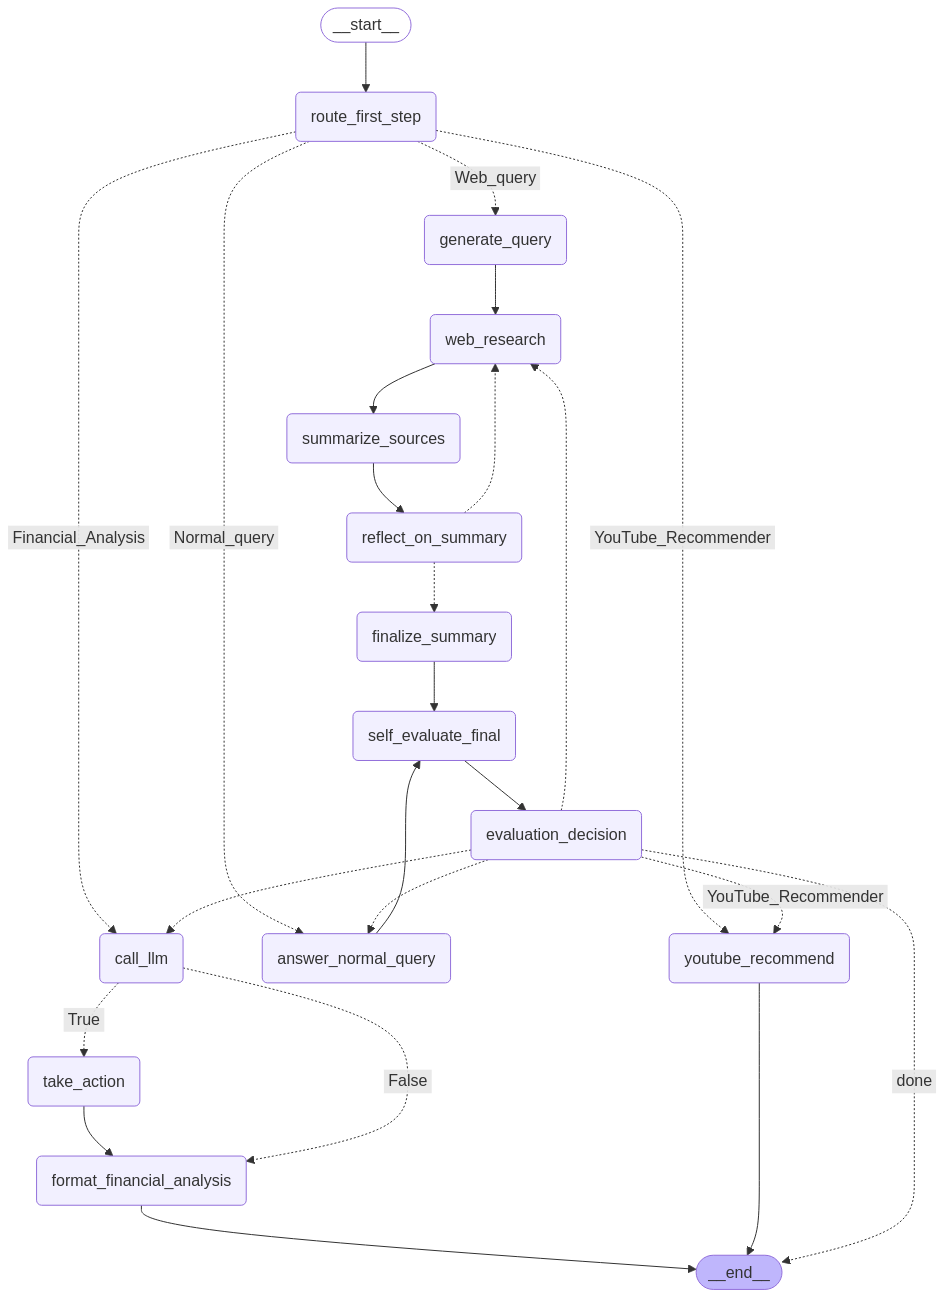

In [10]:
# %%
import os
import json
import getpass
import operator
from enum import Enum
from dataclasses import dataclass, fields
from typing import Any, Dict, List, Optional
from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, Field

# IPython for display (if needed)
from IPython.display import Image, display, Markdown

# Import LangChain and related tools
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.runnables import RunnableConfig
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnableParallel, RunnableLambda, RunnableBranch
from langchain_core.tools import tool, StructuredTool
from langchain_core import tools  # if needed
from langchain_core.runnables import RunnableConfig

# For financial data via yfinance
import yfinance as yf

# For web search and HTML parsing
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen

# For environment variables
from dotenv import load_dotenv

# For YouTube video recommendations
import googleapiclient.discovery
import googleapiclient.errors

# For state graph
from langgraph.graph import StateGraph, START, END

# %%
load_dotenv()

# %%
llm = ChatGroq(model_name='Gemma2-9b-it', api_key=os.getenv('GROQ_API_KEY'))

# %% [markdown]
# ## Prompts for Web Research

# %%
query_writer_instruction_web = """Your goal is to generate a targeted web search query related to financial investments or any finance-related topic specified by the user.

<TOPIC>
{finance_topic}
</TOPIC>

<FORMAT>
Format your response as a JSON object with ALL three of these exact keys:
   - "query": The actual search query string
   - "aspect": The specific aspect of the finance topic being researched
   - "rationale": Brief explanation of why this query is relevant
</FORMAT>

<EXAMPLE>
Example output:
{{
    "query": "best index funds for long-term investment 2025",
    "aspect": "investment strategy",
    "rationale": "Identifying top-performing index funds for long-term portfolio growth"
}}
</EXAMPLE>

Provide your response in JSON format:
"""

summarizer_instruction_web = """<GOAL>
Generate a high-quality summary of the web search results, focusing on financial investments or the specific finance-related topic requested by the user.
</GOAL>

<REQUIREMENTS>
When creating a NEW summary:
1. Highlight the most relevant financial insights, trends, or strategies from the search results.
2. Ensure a coherent flow of information while keeping it concise and actionable.

When EXTENDING an existing summary:
1. Read the existing summary and new search results carefully.
2. Compare the new information with the existing summary.
3. For each piece of new information:
    a. If it builds on an existing point, integrate it smoothly.
    b. If it introduces a new relevant aspect, add a separate paragraph.
    c. If it’s irrelevant to financial investments, ignore it.
4. Ensure all additions align with the user’s finance-related query.
5. Verify that the final output differs from the original summary while improving its depth.

<FORMATTING>
- Start directly with the updated summary, without preamble or titles. Do not use XML tags in the output.
</FORMATTING>
"""

reflection_instructions_web = """You are an expert financial research assistant analyzing a summary about {finance_topic}.

<GOAL>
1. Identify missing details or areas that need deeper exploration.
2. Generate a follow-up question to help expand financial knowledge.
3. Focus on investment strategies, market trends, risk factors, regulations, or financial instruments that weren’t fully covered.
</GOAL>

<REQUIREMENTS>
Ensure the follow-up question is self-contained and provides necessary context for a web search.
</REQUIREMENTS>

<FORMAT>
Format your response as a JSON object with these exact keys:
- "knowledge_gap": Describe what financial information is missing or unclear.
- "follow_up_query": Write a specific question to address this gap.
</FORMAT>

<EXAMPLE>
Example output:
{{
    "knowledge_gap": "The summary does not mention tax implications of investing in ETFs vs. mutual funds.",
    "follow_up_query": "What are the tax advantages and disadvantages of ETFs compared to mutual funds?"
}}
</EXAMPLE>

Provide your analysis in JSON format:
"""

# %% [markdown]
# ## States

# %%
class State(TypedDict):
    route: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender'] = Field(None)
    research_topic: str
    search_query: str
    web_research_results: List[str]
    sources_gathered: List[str]
    research_loop_count: int
    running_summary: str
    messages: List[Any]  # Using Any to include HumanMessage/ToolMessage objects

def create_initial_state(user_query: str) -> State:
    return {
        "route": None,
        "research_topic": user_query,
        "search_query": "",
        "web_research_results": [],
        "sources_gathered": [],
        "research_loop_count": 0,
        "running_summary": "",
        "messages": [HumanMessage(content=user_query)]
    }

# %% [markdown]
# ## Routing Step

# %%
class Route_First_Step(BaseModel):
    # Updated to include YouTube_Recommender
    step: Literal['Web_query', 'Normal_query', 'Financial_Analysis', 'YouTube_Recommender'] = Field(
        None,
        description='Determine whether to perform a web search, answer a normal question, perform a financial analysis, or recommend YouTube videos.'
    )

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    DUCKDUCKGO = "duckduckgo"

@dataclass(kw_only=True)
class Configuration:
    max_web_research_loops: int = int(os.environ.get("MAX_WEB_RESEARCH_LOOPS", "3"))
    search_api: SearchAPI = SearchAPI(os.environ.get("SEARCH_API", "tavily"))
    fetch_full_page: bool = os.environ.get("FETCH_FULL_PAGE", "False").lower() in ("true", "1", "t")
    ollama_base_url: str = os.environ.get("OLLAMA_BASE_URL", "http://localhost:11434/")

    @classmethod
    def from_runnable_config(cls, config: Optional[RunnableConfig] = None) -> "Configuration":
        configurable = config["configurable"] if config and "configurable" in config else {}
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

# %% [markdown]
# ## Web Research Functions

# %%
@traceable
def tavily_search(query, include_raw_content=True, max_results=3):
    api_key = os.environ['TAVILY_API_KEY']
    if not api_key:
        raise ValueError("TAVILY_API_KEY environment variable is not set")
    from tavily import TavilyClient  # Imported here for modularity
    tavily_client = TavilyClient(api_key=api_key)
    return tavily_client.search(query, max_results=max_results, include_raw_content=include_raw_content)

def deduplicate_and_format_sources(search_response, max_tokens_per_source, include_raw_content=False):
    if isinstance(search_response, dict):
        sources_list = search_response['results']
    elif isinstance(search_response, list):
        sources_list = []
        for response in search_response:
            if isinstance(response, dict) and 'results' in response:
                sources_list.extend(response['results'])
            else:
                sources_list.extend(response)
    else:
        raise ValueError("Input must be either a dict with 'results' or a list of search results")

    unique_sources = {}
    for source in sources_list:
        if source['url'] not in unique_sources:
            unique_sources[source['url']] = source

    formatted_text = "Sources:\n\n"
    for source in unique_sources.values():
        formatted_text += f"Source {source['title']}:\n===\n"
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Most relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            char_limit = max_tokens_per_source * 4
            raw_content = source.get('raw_content', '') or ''
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"

    return formatted_text.strip()

def format_sources(search_results):
    return '\n'.join(
        f"* {source['title']} : {source['url']}"
        for source in search_results['results']
    )

def generate_query(state: State, config: RunnableConfig):
    prompt = query_writer_instruction_web.format(finance_topic=state["research_topic"]) + "\nGenerate a query for web search:"
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        query_data = json.loads(output_text)
        return {"search_query": query_data['query']}
    except (json.JSONDecodeError, KeyError) as e:
        print(f"Error parsing JSON: {e}")
        return {"search_query": f"comprehensive analysis of {state['research_topic']}"}

def web_research(state: State, config: RunnableConfig):
    configurable = Configuration.from_runnable_config(config)
    search_api = configurable.search_api.value if isinstance(configurable.search_api, Enum) is False else configurable.search_api.value
    if search_api == "tavily":
        search_results = tavily_search(state["search_query"], include_raw_content=True, max_results=1)
        search_str = deduplicate_and_format_sources(search_results, max_tokens_per_source=1000, include_raw_content=True)
    else:
        raise ValueError(f"Unsupported search API: {configurable.search_api}")
    return {
        "sources_gathered": [format_sources(search_results)],
        "research_loop_count": state["research_loop_count"] + 1,
        "web_research_results": [search_str]
    }

def summarize_sources(state: State, config: RunnableConfig):
    existing_summary = state['running_summary']
    most_recent_web_research = state['web_research_results'][-1]
    if existing_summary:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Existing Summary> \n {existing_summary} \n <Existing Summary>\n\n"
            f"<New Search Results> \n {most_recent_web_research} \n <New Search Results>"
        )
    else:
        human_message_content = (
            f"<User Input> \n {state['research_topic']} \n <User Input>\n\n"
            f"<Search Results> \n {most_recent_web_research} \n <Search Results>"
        )
    prompt = summarizer_instruction_web + "\n" + human_message_content
    result = llm.invoke(prompt)
    running_summary = result.content
    while "<think>" in running_summary and "</think>" in running_summary:
        start = running_summary.find("<think>")
        end = running_summary.find("</think>") + len("</think>")
        running_summary = running_summary[:start] + running_summary[end:]
    return {"running_summary": running_summary}

def reflect_on_summary(state: State, config: RunnableConfig):
    prompt = reflection_instructions_web.format(finance_topic=state['research_topic']) \
             + "\nIdentify a knowledge gap and generate a follow-up web search query based on our existing knowledge: " \
             + state['running_summary']
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        follow_up_query = json.loads(output_text)
    except json.JSONDecodeError:
        print("Error: Could not decode JSON from reflect_on_summary. Response was:", output_text)
        follow_up_query = {"follow_up_query": f"Tell me more about {state['research_topic']}"}
    query = follow_up_query.get('follow_up_query')
    if not query:
        return {"search_query": f"Tell me more about {state['research_topic']}"}
    return {"search_query": query}

def finalize_summary(state: State):
    all_sources = "\n".join(source for source in state['sources_gathered'])
    final_summary = f"## Web Research Summary\n\n{state['running_summary']}\n\n### Sources:\n{all_sources}"
    final_message = HumanMessage(content=final_summary)
    return {"running_summary": final_summary, "messages": [final_message]}

def route_research(state: State, config: RunnableConfig) -> Literal["finalize_summary", "web_research"]:
    configurable = Configuration.from_runnable_config(config)
    if state['research_loop_count'] < configurable.max_web_research_loops:
        return "web_research"
    return "finalize_summary"
# %% [markdown]
# ## Financial Analysis Tools & Functions

# %%
@tool
def company_address(ticker: str) -> str:
    """
    Returns company address for input ticker.
    e.g. company_address: AAPL
    Returns company address for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return " ".join([info[key] for key in ['address1','city','state','zip','country']])

@tool
def fulltime_employees(ticker: str) -> int:
    """
    Returns fulltime employees count for input ticker.
    e.g. company_address: MSFT
    Returns fulltime employees count for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['fullTimeEmployees']

@tool
def last_close_price(ticker: str) -> float:
    """
    Returns last close price for input ticker.
    e.g. company_address: MSFT
    Returns last close price for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['previousClose']

@tool
def EBITDA(ticker: str) -> float:
    """
    Returns EBITDA for input ticker.
    e.g. company_address: AAPL
    Returns EBITDA for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['ebitda']

@tool
def total_debt(ticker: str) -> float:
    """
    Returns total debt for input ticker.
    e.g. company_address: AAPL
    Returns total debt for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalDebt']

@tool
def total_revenue(ticker: str) -> float:
    """
    Returns total revenue for input ticker.
    e.g. company_address: MSFT
    Returns total revenue for ticker MSFT which is stock ticker for Microsoft.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['totalRevenue']

@tool
def debt_to_equity_ratio(ticker: str) -> float:
    """
    Returns debt to equity ratio for input ticker.
    e.g. company_address: AAPL
    Returns debt to equity ratio for ticker AAPL which is stock ticker for Apple Inc.
    """
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.get_info()

    return info['debtToEquity']

finance_tools = [
    company_address,
    fulltime_employees,
    last_close_price,
    EBITDA,
    total_debt,
    total_revenue,
    debt_to_equity_ratio
]
finance_tool_map = {t.name: t for t in finance_tools}

llm_normal = llm
normal_query_prompt = """
You are a financial analyst. Please answer the user's question based on what you know, don't make up anything.
"""

def answer_normal_query(state: State):
    messages = state.get('messages', [])
    system_message = SystemMessage(content=normal_query_prompt + "\nFormat your response in Markdown.")
    response = llm_normal.invoke([system_message] + messages)
    markdown_response = f"## Normal Query Response\n\n{response.content}"
    return {"running_summary": markdown_response, "messages": [HumanMessage(content=markdown_response)]}

llm_financial_analysis = llm.bind_tools(finance_tools, tool_choice='auto')
financial_analysis_prompt = """
You are a financial analyst. You are given tools for accurate data.
"""

def call_llm(state: State):
    messages = state['messages']
    system_prompt = financial_analysis_prompt + "\nFormat your response in Markdown."
    messages = [SystemMessage(content=system_prompt)] + messages
    message = llm_financial_analysis.invoke(messages)
    return {'messages': [message]}

def exists_action(state: State):
    result = state['messages'][-1]
    return len(result.tool_calls) > 0

def take_action(state: State):
    tool_calls = state['messages'][-1].tool_calls
    tool_results = []
    for t in tool_calls:
        try:
            tool_func = finance_tool_map[t['name']]
            result = tool_func.invoke(t['args'])
        except KeyError:
            result = f"Error: Tool {t['name']} not found"
        except Exception as e:
            result = f"Error executing tool: {str(e)}"
        tool_results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
    markdown_output = "## Financial Analysis Results\n\n"
    for result in tool_results:
        markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    return {'messages': tool_results, 'running_summary': markdown_output}

def format_financial_analysis(state: State):
    messages = state['messages']
    tool_results = [msg for msg in messages if isinstance(msg, ToolMessage)]
    if tool_results:
        markdown_output = "## Financial Analysis Results\n\n"
        for result in tool_results:
            markdown_output += f"### {result.name.replace('_', ' ').title()}\n\n{result.content}\n\n"
    else:
        markdown_output = f"## Financial Analysis\n\n{messages[-1].content}"
    return {"running_summary": markdown_output, "messages": [HumanMessage(content=markdown_output)]}

# %% [markdown]
# ## YouTube Video Recommendation Integration

# %%
class YouTubeVideoRecommender:
    def __init__(self, api_key):
        self.api_key = api_key
        self.youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
    
    def get_channel_id(self, channel_name):
        request = self.youtube.search().list(
            part="snippet",
            q=channel_name,
            type="channel",
            maxResults=1
        )
        response = request.execute()
        if response['items']:
            return response['items'][0]['id']['channelId']
        return None
    
    def search_videos_in_channel(self, channel_id, query, max_results=10):
        request = self.youtube.search().list(
            part="snippet",
            channelId=channel_id,
            q=query,
            type="video",
            maxResults=max_results
        )
        response = request.execute()
        videos = []
        for item in response['items']:
            video_id = item['id']['videoId']
            title = item['snippet']['title']
            description = item['snippet']['description']
            published_at = item['snippet']['publishedAt']
            thumbnail = item['snippet']['thumbnails']['high']['url']
            channel_title = item['snippet']['channelTitle']
            videos.append({
                'video_id': video_id,
                'title': title,
                'description': description,
                'published_at': published_at,
                'thumbnail': thumbnail,
                'channel': channel_title,
                'url': f"https://www.youtube.com/watch?v={video_id}"
            })
        return videos

    def recommend_videos(self, query, channels, videos_per_channel=5):
        all_videos = []
        for channel in channels:
            if channel.startswith('UC') and len(channel) == 24:
                channel_id = channel
            else:
                channel_id = self.get_channel_id(channel)
                if not channel_id:
                    print(f"Could not find channel: {channel}")
                    continue
            videos = self.search_videos_in_channel(channel_id, query, videos_per_channel)
            all_videos.extend(videos)
        return all_videos

def youtube_recommend(state: State, config: RunnableConfig):
    api_key = os.getenv("YOUTUBE_API_KEY")
    if not api_key:
        raise ValueError("YOUTUBE_API_KEY is not set")
    recommender = YouTubeVideoRecommender(api_key)
    # List of favorite channels (names or IDs)
    favorite_channels = [
        "ZEE Business",
        "Economic Times",
        "Times Now",
        "Times Now Business",
        "Times Now News",
        "Times Now Politics",
        "Times Now Sports",
        "Times Now Science",
        "Times Now Technology",
        "Pranjal Kamra",
        "Yadnya Investment Academy",
        "CA Rachana Phadke Ranade",
        "Invest Aaj For Kal",
        "Market Gurukul",
        "Warikoo",
        "Asset Yogi",
        "Trading Chanakya",
        "Trade Brains",
        "B Wealthy",
        "Capital Pritika",
        "The Urban Fight",
        "Kritika Yadav",
        "Gurleen Kaur Tikku"
    ]
    query = state["research_topic"]
    recommendations = recommender.recommend_videos(query, favorite_channels, videos_per_channel=1)
    if not recommendations:
        summary = f"No matching videos found for query: {query}"
    else:
        summary = f"## YouTube Video Recommendations for '{query}'\n\n"
        for i, video in enumerate(recommendations, 1):
            summary += f"### {i}. {video['title']}\n"
            summary += f"- Channel: {video['channel']}\n"
            summary += f"- URL: {video['url']}\n"
            summary += f"- Published: {video['published_at']}\n\n"
    return {"running_summary": summary, "messages": [HumanMessage(content=summary)]}

# %% [markdown]
# ## Final Route Builder

def self_evaluate(input_text):
    parts = input_text.split("|||")
    query = parts[0]
    response = parts[1]
    sources = parts[2] if len(parts) > 2 else ""
    
    evaluation_prompt = f"""
    Evaluate the following response to the query:
    
    QUERY: {query}
    RESPONSE: {response}
    SOURCES: {sources}
    
    Assess based on:
    1. Factual accuracy (Does it match the sources?)
    2. Completeness (Does it address all aspects of the query?)
    3. Relevance (Is the information relevant to the query?)
    4. Hallucination (Does it contain information not supported by sources?)
    
    Return a confidence score from 0-10 and a brief explanation.
    """
    
    evaluation = llm.predict(evaluation_prompt)
    return evaluation

def evaluate_response(state: State, config: RunnableConfig):
    query = state.get("research_topic", "")
    response = state.get("running_summary", "")
    sources = "\n".join(state.get("sources_gathered", [])) or "No sources available"
    input_text = f"{query}|||{response}|||{sources}"
    evaluation = self_evaluate(input_text)
    final_summary = response + "\n\n## Self Evaluation\n\n" + evaluation
    return {"running_summary": final_summary, "messages": [HumanMessage(content=final_summary)]}

def evaluation_decision(state: State, config: RunnableConfig):
    final_text = state.get("running_summary", "")
    prompt = f"""
    The final output and self-evaluation are as follows:
    {final_text}
    
    Based on the above, do you think additional insights should be added?
    If yes, return a JSON object with the key "next_route" set to one of the following options:
      - "call_llm" for additional financial analysis,
      - "web_research" for further web research,
      - "answer_normal_query" for more normal query insights,
      #- "parallel_branches" to combine branches again.
    If no additional insights are needed, return "done".
    
    For example:
    {{"next_route": "call_llm"}}
    """
    result = llm.invoke(prompt)
    output_text = result.content.strip()
    try:
        decision = json.loads(output_text)
        next_route = decision.get("next_route", "done")
    except Exception as e:
        print("Error in evaluation_decision:", e)
        next_route = "done"
    # Optionally update state with next_route
    state["next_route"] = next_route
    return {"next_route": next_route}


# %%


def get_route(state: State) -> str:
    return state["route"]

def update_router():
    final_router = StateGraph(State)
    final_router.add_node("route_first_step", call_route_first_step)
    final_router.add_node("generate_query", generate_query)
    final_router.add_node("web_research", web_research)
    final_router.add_node("summarize_sources", summarize_sources)
    final_router.add_node("reflect_on_summary", reflect_on_summary)
    final_router.add_node("finalize_summary", finalize_summary)
    final_router.add_node('call_llm', call_llm)
    final_router.add_node('take_action', take_action)
    final_router.add_node('format_financial_analysis', format_financial_analysis)
    final_router.add_node('answer_normal_query', answer_normal_query)
    final_router.add_node('youtube_recommend', youtube_recommend)
    final_router.add_node("self_evaluate_final", evaluate_response)
    final_router.add_node("evaluation_decision", evaluation_decision)

    final_router.add_edge(START, "route_first_step")
    final_router.add_conditional_edges("route_first_step", get_route, {
        'Web_query': 'generate_query',
        'Normal_query': 'answer_normal_query',
        'Financial_Analysis': 'call_llm',
        'YouTube_Recommender': 'youtube_recommend'
    })
    
    final_router.add_edge("answer_normal_query", 'self_evaluate_final')
    
    final_router.add_conditional_edges(
        "call_llm",
        exists_action,
        {True: "take_action", False: "format_financial_analysis"}
    )
    final_router.add_edge("take_action", "format_financial_analysis")
    final_router.add_edge("format_financial_analysis", END)
    
    final_router.add_edge("generate_query", "web_research")
    final_router.add_edge("web_research", "summarize_sources")
    final_router.add_edge("summarize_sources", "reflect_on_summary")
    final_router.add_conditional_edges("reflect_on_summary", route_research)
    final_router.add_edge("finalize_summary", 'self_evaluate_final')

    final_router.add_edge("self_evaluate_final", 'evaluation_decision')
    # New branch: YouTube recommendation goes directly to END
    final_router.add_conditional_edges("evaluation_decision", get_route, {
        'done': END,
        'call_llm': 'call_llm',
        'web_research': 'web_research',
        'answer_normal_query': 'answer_normal_query',
        'YouTube_Recommender': 'youtube_recommend'
    })
    final_router.add_edge("youtube_recommend", END)
    
    return final_router.compile()

def call_route_first_step(state: State):
    router_response = llm.with_structured_output(Route_First_Step).invoke(state["research_topic"])
    return {"route": router_response.step}

def validate_state_transition(old_state: State, new_state: State):
    required_fields = set(State.__annotations__.keys())
    missing = required_fields - set(new_state.keys())
    if missing:
        raise ValueError(f"Missing state updates for: {missing}")
    return True

# %% [markdown]
# ## Running the Integrated Agent

# %%
final_model = update_router()
display(Image(final_model.get_graph().draw_mermaid_png()))

In [ ]:
# %%
# Example initial state; you can change the query and expected route.
# For a YouTube recommendation, ensure the routing LLM returns "YouTube_Recommender" for your input.
initial_state = create_initial_state("What are the latest trends in sustainable investing?")

# You might want to set the route manually during testing:
initial_state["route"] = "YouTube_Recommender"
result = final_model.invoke(initial_state)

validate_state_transition(initial_state, result)
print("Final state validated successfully!")
print("Summary:", result["running_summary"])

# %%
Markdown(result['messages'][-1].content)
